# Chapter 1 - My First Simulation (10 min)
![Laplace](PyFEMP_src/assets/laplace_a.jpeg?raw=true "A simple laplace bvp.")

For a PyFEMP simulation we start with importing four things into our python session:
 * numpy
 * matplotlib
 * PyFEMP
 * the element we will use

In [7]:
# Import Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import the PyFEMP package
import PyFEMP

For this example we use a quadrilateral finite element for solving the head conductivity problem. For its documentation, see ... . 

By convention we introduce the PyFEMP element of a simulation with the pattern:
```
import ELEMENTFILE as ELEMENT
```

Here we use a PyFEMP element file: `PyFEMP.elements.Laplace_Q1`

In [3]:
# Importing the element file
import PyFEMP.elements.Laplace_Q1 as ELEMENT 

We start a simulation by creating a FEM_Simulation object.

The Element were about to use was imported as `ELEMENT` which is the only required argument. 

Here we additionally set the simulation to be verbose from the beginning on (opional).

In [4]:
MyFirstSimulation = PyFEMP.FEM_Simulation(ELEMENT, verbose=True)

FEM Solver Instance Created
Simulation dimensions:                     2
Number of element nodes:                   4
Names of nodal degrees of freedom:         ['T']
Names of element parameters:               ['alpha_q']
Names of available postprocessing fields:  ['T']


In [5]:
# A simulation may provide a lot of information which can be controlled by two switches which are off by default. Their value can be changed anytime during the simulation
MyFirstSimulation.verbose        = True
MyFirstSimulation.verbose_system = True

Now we define the problem, starting with a definition for the mesh. With this very simple example we can define the mesh manually

In [6]:
# Add a FEM-Mesh
XI   = np.array([[0.0, 0.0],[1.0, 0.0],[1.0, 1.0],[0.0, 1.0]])
Elmt = np.array([[0,1,2,3]])
MyFirstSimulation.Add_Mesh(XI, Elmt)

Mesh NoNodes          :  4
Mesh Dimension        :  2
Mesh NoElements       :  1
Mesh Nodes per Element:  4
 Finite Elemenmt Mesh Read!


Next we introduce the material parameters. Here 'All' elements share the same parameter vector.

In [7]:
# Set homogenous material
MyFirstSimulation.Add_Material([1.0], 'All')

 Material set for All Elements


Two sets of boundary conditions must be set in this problem. At first we introduce the essential conditions (or Dirichlet), where a fixed value is prescirbed.

The Add_EBC command is used to introduce this type of boundary conditions. It takes three arguments. The first is a condition string, which is evaluated to find the nodes by their coordinates. In this example we do know the nodal coordinates to target precisely, however the second way of specifying a node (upper right corner) shows the capabilities of this method. The second argument is a string with the nodal degree of freedom name as specified in the element file. In this case we address the temperature `'T'`. The last argument specifies the prescribed value.

In [8]:
# Add essential boundary conditions
MyFirstSimulation.Add_EBC('x==0 and y==0', 'T', 0.0)
MyFirstSimulation.Add_EBC('x>0.8 and y>0.8', 'T', 3.0)

>> Note that all boundary conditions are multiplied with a scalar, introduced in the NextStep command later.

In a similar fashion we introduce the natural (or Neumann) boundary condition. This will be a heat flux at the non prescribed nodes.

In [9]:
# Add natural boundary conditions
MyFirstSimulation.Add_NBC('x==1 and y==0', 'T', -100.0)
MyFirstSimulation.Add_NBC('x==0 and y==1', 'T',  100.0)

Once the boundary value problem is prescribed, we enter the analsis phase of the simulation. After this point, all boundary conditions are fixed and history/degrees of freedom fields are initialized.

In [10]:
# Enter analysis phase - get ready for solving the problem
MyFirstSimulation.Analysis()

Entering Analysis phase
---------------------------------
FE Setup Summary :
NoElementNodes   : 4
NoNodeDofs       : 1
ElementDofNames  : ['T']
ElementPostNames : ['T']
NoElementHistory : 0
NoElements       : 1
NoNodes          : 4
NoDofs           : 4
NoEssential BC   : 2
NoNatural BC     : 2
---------------------------------


In [11]:
# Check the vector of degrees of freedom after initialization
MyFirstSimulation.DI

array([0., 0., 0., 0.])

While all values and loads are initialied by zero, we introduce a time/load step to apply the boundary conditions to the simulation.
The `NextStep` command takes two arguments. The first is the absolute time, for which we attempt to find a solution. The second argument is the value of the load multiplier, applied to all boundary conditions.

Note that although the problem is stready state, we introduce a time, which value is not relevant here. Also because the problem is linear, the load can be applied at once immediately.

In [12]:
# Make a time step
MyFirstSimulation.NextStep(1.0, 1.0)


Current Time : 1.0000005.2


To utilize the implemented Newton-Raphson algorithm to solve the problem, we invoke a predefined macro to execute `NewtonIteration`s. Details on this will be provided later.

Recognize that we print out the return of the function call, to obtain an indicator value for satisfaction of the residual.

To limit the amount of output, we will switch the verboseness off. However, feel free to inspect the output with verboseness on.

In [13]:
# Typical solution procedure for a linear problem,
# by calling NewtonIteration() twice to inspect its output
MyFirstSimulation.verbose        = False
print( MyFirstSimulation.NewtonIteration() )
print( MyFirstSimulation.NewtonIteration() )

      |R|    : 141.42312410.8
      |dDI|  : 141.43726510.8
141.43019444239093
      |R|    : 0.00000010.8
      |dDI|  : 0.00000010.8
0.0


Each call of `NewtonIteration()` produces two outputs.

`|R|` is the norm of the current residual vector.

`|dDI|` is the norm of the increment of the increment of the degree of freedoms in the Newton iteration.

The value returned by the functions (and printed here) is `sqrt(|R|*|dDI|)`.

Recognize that the last output is in fact zero, indicating a converged solution with respect to the Newton-Raphson scheme.

At last we visualize the result using matplotlib.
The `ShowMesh` command takes various options, to plot into an matplotlib axes, provided as an argument.

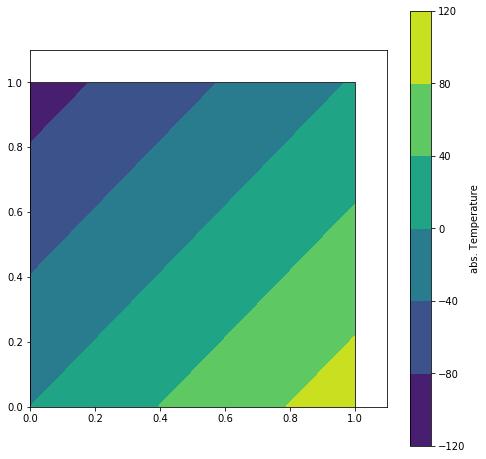

In [14]:
# create a new matplotlib plot containing of a fig (the canvas) and a ax (the graph) 
fig, ax = plt.subplots(1,1, figsize=(8.0, 8.0))

# use ShowMesh to plot into the axes
# here we plot the postprocessing field 'T' which are the nodal temperatures
temperatureplot = MyFirstSimulation.ShowMesh(ax, PostName='T')

# adding a legend with a proper description
legend = fig.colorbar(temperatureplot)
legend.ax.set_ylabel('abs. Temperature')

# visualize the plot in any case
plt.show()

Also we can take a look at the whole degree of freedom vector. Note that this is organized in a nodal fashion, such that its order is the same as the nodal coodrinates we provided in the problem definition.

In [15]:
# get the actual degree of freedom vector
MyFirstSimulation.DI

array([  0. , 101.5,   3. , -98.5])

We can see that the essential boundary conditions are actually satisfied by the prescribed values 0 and 3. On the upper left corner we have set a positive load value, which indicates a heat flux out of the domain, resulting in the lowest temperature at this point. The opposite can be observed on the lower right corner, where a negative load value implies heat flix inside the domain.

# Chapter 2 - Insights (30 min)
In this chapter we will take a closer look to what happens under the hood when PyFEMP solves a boundary value problem.
In Chapter 1 we have covered the basic mechanism to define a boundary value problem. Here we will operate on the same problem, except with a second element.

In [16]:
# Setup the boundary value problem of Chapter 1
# Note that we use the name FEM for the simulation now
import numpy as np
import matplotlib.pyplot as plt
import PyFEMP
import PyFEMP.elements.Laplace_Q1 as ELEMENT 

FEM = PyFEMP.FEM_Simulation(ELEMENT)

XI   = np.array([[0.0, 0.0],[0.5, 0.0],[0.5, 1.0],[0.0, 1.0],[1.0, 0.0],[1.0, 1.0]])
Elmt = np.array([[0,1,2,3],[1,4,5,2]])
FEM.Add_Mesh(XI, Elmt)
FEM.Add_Material([1.0], 'All')

FEM.Add_EBC('x==0 and y==0', 'T', 0.0)
FEM.Add_EBC('x==1 and y==1', 'T', 3.0)
FEM.Add_NBC('x==1 and y==0', 'T', -100.0)
FEM.Add_NBC('x==0 and y==1', 'T',  100.0)

FEM.Analysis()
FEM.NextStep(1.0, 1.0)

FEM Solver Instance Created
Entering Analysis phase
---------------------------------
FE Setup Summary :
NoElementNodes   : 4
NoNodeDofs       : 1
ElementDofNames  : ['T']
ElementPostNames : ['T']
NoElementHistory : 0
NoElements       : 2
NoNodes          : 6
NoDofs           : 6
NoEssential BC   : 2
NoNatural BC     : 2
---------------------------------

Current Time : 1.0000005.2


Here we will investigate how PyFEMP will build up the linear system of equations to solve and how it handles these solutions.
**This might be usefull when debugging but mostly one would use the macro NewtonIteration()!**

In PyFEMP it is possible to call each element and inspect its output, which is exactly the call which PyFEMP will make. Note that here we use the function specific verbose switch (optional) to get additional information.

Despite the output, we get the element vector and matrix returned by the function for own usage, e.g. prodicing a matrix plot in matplotlib.

Calling  :  0
Elmt XI  :  [0.  0.  0.5 0.  0.5 1.  0.  1. ]
Elmt UI  :  [0. 0. 0. 0.]
Elmt Mat :  [1.0]
Elmt Hn  :  []
Elmt Ht  :  []
Element Vector : [0. 0. 0. 0.]
Element Matrix :
[[-0.83333333  0.58333333  0.41666667 -0.16666667]
 [ 0.58333333 -0.83333333 -0.16666667  0.41666667]
 [ 0.41666667 -0.16666667 -0.83333333  0.58333333]
 [-0.16666667  0.41666667  0.58333333 -0.83333333]]


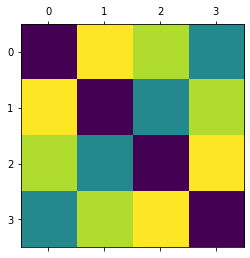

In [17]:
# Call a single element, here 0:
element_vector, element_matrix = FEM.CallElement(0, verbose = True)

# plot the element matrix
plt.matshow(element_matrix)

Notice that the essential boundary conditions are available right after the `NextStep()` command and hence visible to the element.

The next step whould be to call all the elements and assemble their contributions (element vectors and matrices) into the global vector/ matrix accodring to the mesh connectivity.

Global Vector : [ 0.    1.25  1.75  0.   -0.5  -2.5 ]
Global Matrix :
[[-0.83333333  0.58333333  0.41666667 -0.16666667  0.          0.        ]
 [ 0.58333333 -1.66666667 -0.33333333  0.41666667  0.58333333  0.41666667]
 [ 0.41666667 -0.33333333 -1.66666667  0.58333333  0.41666667  0.58333333]
 [-0.16666667  0.41666667  0.58333333 -0.83333333  0.          0.        ]
 [ 0.          0.58333333  0.41666667  0.         -0.83333333 -0.16666667]
 [ 0.          0.41666667  0.58333333  0.         -0.16666667 -0.83333333]]


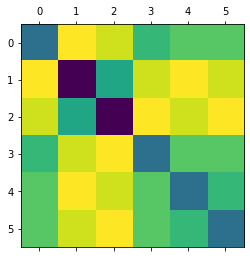

In [18]:
global_vector, global_matrix = FEM.Assemble(verbose=True)

# plot the global matrix
plt.matshow(global_matrix)

In [19]:
# compute determinant and eigenvalues of global_matrix 
print('determinant: ',np.linalg.det(global_matrix))

print('eigenvalues: ',np.linalg.eigvals(global_matrix))

determinant:  -1.5469505405843365e-16
eigenvalues:  [-3.00000000e+00 -1.66685019e-16 -1.40824829e+00 -1.00000000e+00
 -5.91751710e-01 -6.66666667e-01]


Note that the global vector/matrix are not yet reduced doe to essential boundary conditions, not are the natural boundary conditions applied to the vector.

Consequently the global matrix is singular! Hence its determinant is zero.

Also there is one zero eigenvalue, indicating that we do need to apply one scalar boundary condition. This give reason to the name **essential** boundary condition. However we have specified even two (lower left/ upper right temperature) which will be considered in the next step.

The command `FormLinearSystem` is called everytime in the `NewtonIteration` command. Here, all boundary conditions are applied totally. Also the system matrix/vector is reduced such that a valid linear system is obtained.
In order to do so, it applies the global vector of conservative loads which was build from the natural (or Neumann) boundary conditions.
The reduction is done by using a mapping operator which also performes the inverse operation. In a view steps we will follow the solution procedure manually, to make clear what that means.

At first we take a look at the global vector of degrees of freedom, the global vector of conservative loads and the assembled global vector as obtained from `Assemble`.

Recognize that all are of size of the global number of degrees of freedom!

In [20]:
# global vector of all degrees of freedom
print('global dof vector: ')
print(FEM.DI)

print('global vector of conservative loads: ')
print(FEM.R_ext)

print('global vector of element contrubutions: ')
print(global_vector)

global dof vector: 
[0. 0. 0. 0. 0. 3.]
global vector of conservative loads: 
[   0.    0.    0.  100. -100.    0.]
global vector of element contrubutions: 
[ 0.    1.25  1.75  0.   -0.5  -2.5 ]


In order to provide the linear system (`LHS=RHS`), the global right hand side is build from the global vector of element contributions $\boldsymbol{P}$ and the global vector of conservative loads $\boldsymbol{F}$.
To we obtain $\boldsymbol{R} = \boldsymbol{F} - \boldsymbol{P}$.

In [21]:
manual_global_RHS = FEM.R_ext - global_vector
print(manual_global_RHS)

[  0.    -1.25  -1.75 100.   -99.5    2.5 ]


Now, we need to take care of erasing the rows/columns of the system according to the fixed degrees of freedom. 
For this we use a reduction operator `I_red`.

At this point we call the `FormLinearSystem` function and investigate its output:

In [22]:
reduced_RHS, reduced_LHS, I_red = FEM.FormLinearSystem()

In [23]:
# The ouptupt of FormLinearSystem is our 'manually' computed global rhs, but reduced using I_red
print(reduced_RHS)
print(I_red.dot(manual_global_RHS))

[ -1.25  -1.75 100.   -99.5 ]
[ -1.25  -1.75 100.   -99.5 ]


In [24]:
# norm of the reduced residual vector
print('norm(reduced_RHS): ',np.linalg.norm(reduced_RHS))

norm(reduced_RHS):  141.08463771793157


In [25]:
# Also we get the reduced tangent matrix (LHS) which is not singular anymore due to the reduction
print(reduced_LHS)

# reduction of the matrix can be performed also manually using the reduction I_red on both sides of the matrix
print(
    I_red.dot(global_matrix.dot(I_red.T))
)

[[-1.66666667 -0.33333333  0.41666667  0.58333333]
 [-0.33333333 -1.66666667  0.58333333  0.41666667]
 [ 0.41666667  0.58333333 -0.83333333  0.        ]
 [ 0.58333333  0.41666667  0.         -0.83333333]]
[[-1.66666667 -0.33333333  0.41666667  0.58333333]
 [-0.33333333 -1.66666667  0.58333333  0.41666667]
 [ 0.41666667  0.58333333 -0.83333333  0.        ]
 [ 0.58333333  0.41666667  0.         -0.83333333]]


We can see that `FormLinearSystem` returns the linear system of equations to be solved, using the current state of boundary conditions. 

Notice that this system is 4x4 and as such precisely the size of our system of equations.

It is common before solving the linear system to investigate the norm of the reduced right hand side to see wether the iterative scheme has converges already.

Let's solve the linear system:

$\boldsymbol{K}_{\text{red}} \, \Delta \boldsymbol{d}_{\text{red}} = \boldsymbol{R}_{\text{red}}$

In [26]:
reduced_solution_vector = np.linalg.solve(reduced_LHS, reduced_RHS)
print(reduced_solution_vector)

[  16.65384615  -13.65384615 -121.23076923  124.23076923]


In [27]:
# norm of the reduced_solution_vector
print('norm(reduced_RHS): ',np.linalg.norm(reduced_solution_vector))

norm(reduced_RHS):  174.91129620027843


After obtaining the linear solution vector, we investigate its norm. This is another criterion to check for convergence in the interative solution procedure. While it strongly depends on the problem, usually one aims for either one of these norms to be below a certain tolerance. A near zero residual (`|R|`) means equilibrium in terms of the implemented differential equation, while almost zero change in increments (`|dDI|`) indicates that the Newton scheme has converged. 

The function `NewtonIteration` returns the root of the product of both `sqrt(|R|*|dDI|)` as a compromise criterion.

The elegant aspect in the mapping operator `I_red` is that it can be used for the inverse operation as well! So applying it to the reduced solution vector results in the unreduced counterpart, which can be additively applied to the general global vector of degrees of freedom as demanded in the Newton algorithm $\boldsymbol{d} = \boldsymbol{d} + \Delta \boldsymbol{d}$.

In [28]:
# reduced solution vector (size=4)
delta_D_red = reduced_solution_vector
print(delta_D_red)

# unreduced solution vector (size=6)
delta_D = delta_D_red.dot(I_red)
print(delta_D)

# update the degress of freedom (manually)
FEM.DI += delta_D

[  16.65384615  -13.65384615 -121.23076923  124.23076923]
[   0.           16.65384615  -13.65384615 -121.23076923  124.23076923
    0.        ]


It is well knwon that for a linear problem such as this, the first solution of the linear system is in fact the solution. Thus as we have just applied it to the simulations global degree of freedom vector, it is available and can be plotted.

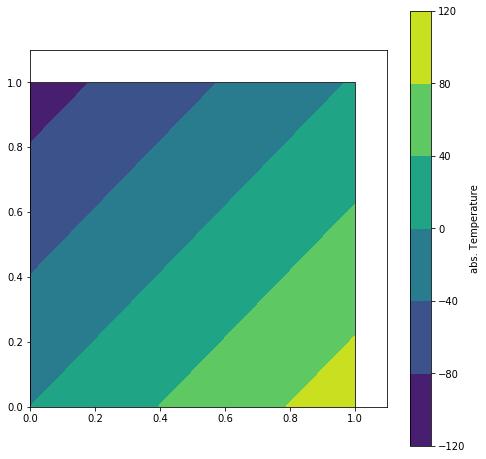

In [29]:
# create a new matplotlib plot containing of a fig (the canvas) and a ax (the graph) 
fig, ax = plt.subplots(1,1, figsize=(8.0, 8.0))

# use ShowMesh to plot into the axes
# here we plot the postprocessing field 'T' which are the nodal temperatures
temperatureplot = MyFirstSimulation.ShowMesh(ax, PostName='T')

# adding a legend with a proper description
legend = fig.colorbar(temperatureplot)
legend.ax.set_ylabel('abs. Temperature')

# visualize the plot in any case
plt.show()

Even though we have used two elements here, the solution looks similar, if not down to the precise numeric values. 
We can however redo the procedure of performing NewtonIterations, i.e. solving the linear system to double check. 
However for this we will use the `NewtonIteration` function again for convenience.

In [30]:
# Execute more than once 
print(FEM.NewtonIteration())

      |R|    : 0.00000010.8
      |dDI|  : 0.00000010.8
1.8766136128756836e-14


To leave you with a good feeling about the solution, we will here utilize a build in meshing function to provide a more dense discretization.
Feel free to check on the solution for varying 'elements_per_edge'.

In [15]:
# Setup the boundary value problem of Chapter 1
import numpy as np
import matplotlib.pyplot as plt
import PyFEMP
import PyFEMP.elements.Laplace_Q1 as ELEMENT 

FEM = PyFEMP.FEM_Simulation(ELEMENT)

# Use build in mesher e.g. 'msh_rec'
elements_per_edge = 35
XI, Elem = PyFEMP.msh_rec([0.0, 0.0], [1.0, 1.0], [elements_per_edge, elements_per_edge])
FEM.Add_Mesh(XI, Elem)
FEM.Add_Material([1.0], 'All')

FEM.Add_EBC('x==0 and y==0', 'T', 0.0)
FEM.Add_EBC('x==1 and y==1', 'T', 3.0)
FEM.Add_NBC('x==1 and y==0', 'T', -100.0)
FEM.Add_NBC('x==0 and y==1', 'T',  100.0)

FEM.Analysis()
FEM.NextStep(1.0, 1.0)

FEM Solver Instance Created
Entering Analysis phase
---------------------------------
FE Setup Summary :
NoElementNodes   : 4
NoNodeDofs       : 1
ElementDofNames  : ['T']
ElementPostNames : ['T']
NoElementHistory : 0
NoElements       : 1225
NoNodes          : 1296
NoDofs           : 1296
NoEssential BC   : 2
NoNatural BC     : 2
---------------------------------

Current Time : 1.0000005.2


In [16]:
print( FEM.NewtonIteration() )
print( FEM.NewtonIteration() )

      |R|    : 141.42665910.8
      |dDI|  : 1670.32051110.8
486.032766467146
      |R|    : 0.00000010.8
      |dDI|  : 0.00000010.8
3.2383430377671663e-12


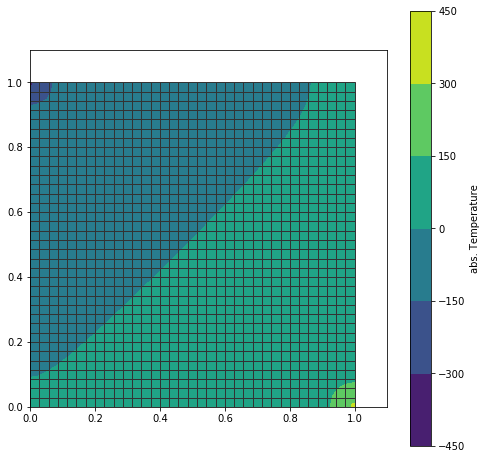

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8.0, 8.0))

temperatureplot = FEM.ShowMesh(ax, PostName='T')

legend = fig.colorbar(temperatureplot)
legend.ax.set_ylabel('abs. Temperature')

plt.show()